In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'C:\\Users\\asus\\Documents\\GitHub\\ML_course\\projects\\project1\\data\\train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [3]:
from implementations import *

In [4]:
#Normalize the data
centered_data = tX - np.mean(tX, axis=0)
tX = centered_data / np.std(centered_data, axis=0)
y[y == -1] = 0

In [5]:
#Find the correlations btw all columns and delete rows that are highly correlated
corr_mtx = np.identity(30)
for i in range(31):
    for j in range(i,30):
        corr_mtx[i,j] = np.corrcoef(tX[:,i], tX[:,j])[0,1]
        if corr_mtx[i,j]>0.95 and i!=j:
            print(i,j)

4 6
4 12
4 26
4 27
4 28
6 12
6 26
6 27
6 28
9 29
12 26
12 27
12 28
23 24
23 25
24 25
26 27
26 28
27 28


In [6]:
tX = np.delete(tX, np.array([6, 12,24,25,26,27,28,29]), axis=1)

In [7]:
least_squares_GD(y, tX, np.ones(tX.shape[1]), 50, 0.3)

(array([ 4.74321259e-02, -1.53963212e-01, -1.37635737e-01,  1.33744517e-01,
         8.92468835e-02,  2.69903296e-01,  7.71949367e-02,  6.08511647e-02,
         4.22754698e-02,  1.54108065e-03,  1.38481014e-01,  2.28383070e-01,
         4.78779208e-04,  1.48033753e-04,  1.33319320e-01,  1.64120780e-03,
         9.00020726e-04,  1.25322046e-01,  1.80818705e-03,  8.89206402e-02,
         1.77560082e-02,  1.94047648e-01]), 1.132196427852129)

0.2945519130787804

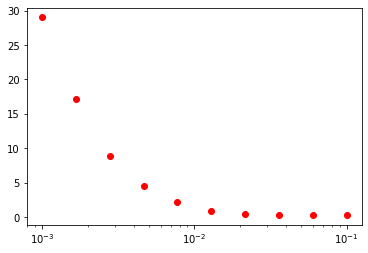

In [8]:
num_gamma = 10
least_squares_loss = np.ones(num_gamma)
gamma = np.logspace(-3, -1, num_gamma)
for i in range(num_gamma):
    least_squares_loss[i] = least_squares_GD(y, tX, np.ones(tX.shape[1]), 100, gamma[i])[1]
plt.plot(gamma, least_squares_loss, 'ro')
plt.xscale('log')
np.min(least_squares_loss)

In [9]:
least_squares_SGD(y, tX, np.ones(tX.shape[1]), 200, 0.3)

(array([-1.63558483e+36, -1.58028818e+36, -9.11379673e+35, -9.09855532e+34,
        -1.97494806e+35, -2.79893350e+35, -7.34168307e+35, -7.44939125e+35,
        -5.23057034e+35, -1.40520559e+36, -1.56277002e+35, -5.72984527e+35,
         3.54107201e+35, -1.55479738e+35, -1.88677199e+36,  9.71227125e+34,
         1.34741677e+36, -2.99397443e+35, -1.48784729e+36, -2.67267639e+35,
        -2.44540147e+34,  4.61366082e+35]), 3.047099836278917e+73)

0.4383246141539431

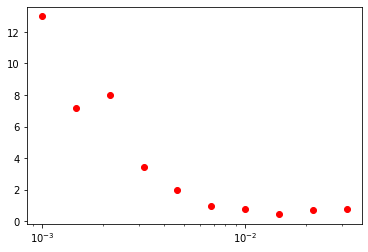

In [10]:
num_gamma = 10
least_squares_loss_SG = np.ones(num_gamma)
gamma = gamma = np.logspace(-3, -1.5, num_gamma)
for i in range(num_gamma):
    least_squares_loss_SG[i] = least_squares_SGD(y, tX, np.ones(tX.shape[1]), 200, gamma[i])[1]
plt.plot(gamma, least_squares_loss_SG, 'ro')
plt.xscale('log')
np.min(least_squares_loss_SG)

In [11]:
least_squares(y, tX)

(array([ 0.01457775, -0.12673899, -0.12745413, -0.01694001, -0.08993026,
         0.20927023,  0.13388932, -0.00050725, -0.07308316, -0.09132203,
         0.05763819,  0.11023857, -0.00032171, -0.00054586,  0.15797759,
        -0.00043332,  0.0012556 ,  0.06044576,  0.00050283, -0.03165107,
        -0.09071907,  0.07996976]), 0.28744464469757697)

In [12]:
ridge_regression(y, tX, 0.02)

(array([ 0.02074855, -0.11421443, -0.0920186 , -0.00077868, -0.04247097,
         0.13761996,  0.10431579, -0.00810759, -0.03863204, -0.06988994,
         0.05813532,  0.09582814, -0.00044968, -0.00074823,  0.10749807,
        -0.00036194,  0.00119516,  0.04380157,  0.00059088, -0.03638813,
        -0.06717489,  0.05004489]), 0.2906412127080359)

0.28744640480134276

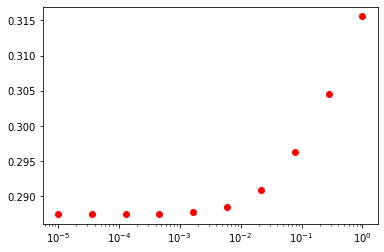

In [13]:
num_lambda = 10
ridge_regression_loss = np.ones(num_lambda)
lambda_ =  np.logspace(-5, 0, num_lambda)
for i in range(num_lambda):
    ridge_regression_loss[i] = ridge_regression(y, tX, lambda_[i])[1]
plt.plot(lambda_, ridge_regression_loss, 'ro')
plt.xscale('log')
np.min(ridge_regression_loss)

In [159]:
from implementations import *

In [184]:
logistic_regression(y[0:10000], tX[0:10000], np.zeros(tX.shape[1]), 100000, 1)

(array([ 6.06141421e-01,  1.08213957e-01, -1.55596451e-01,  2.35580435e-03,
         9.59173419e-02,  6.29726838e-02,  8.78330141e-02,  1.01639097e-02,
        -5.57404974e-03,  7.64100957e-02, -9.21793152e-02,  1.25360444e-01,
         1.15504886e-01,  9.28510177e-03, -2.10230041e-04, -1.13927451e-02,
         4.20613967e-03,  7.50216296e-03,  2.14320453e-02, -1.61907751e-03,
         6.70032082e-02,  5.91413697e-02,  7.56913768e-02]),
 0.7748268588155651)

In [193]:
reg_logistic_regression(y[0:10000], tX[0:10000], 0.01, np.zeros(tX.shape[1]), 10000, 1)

(array([ 5.96141421e-01,  1.08213957e-01, -1.55596451e-01,  2.35580435e-03,
         9.59173419e-02,  6.29726838e-02,  8.78330141e-02,  1.01639097e-02,
        -5.57404974e-03,  7.64100957e-02, -9.21793152e-02,  1.25360444e-01,
         1.15504886e-01,  9.28510177e-03, -2.10230041e-04, -1.13927451e-02,
         4.20613967e-03,  7.50216296e-03,  2.14320453e-02, -1.61907751e-03,
         6.70032082e-02,  5.91413697e-02,  7.56913768e-02]),
 0.7742459327447615)

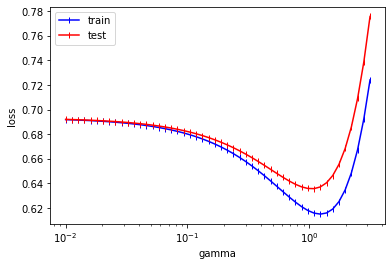

In [235]:
tr, te, gammas = cross_validation_gamma(y[0:10000], tX[0:10000])

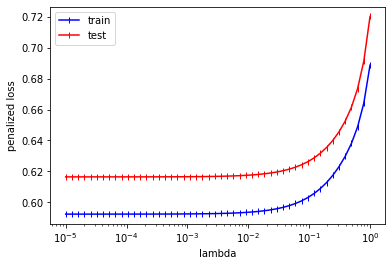

In [236]:
tr, te, lambdas = cross_validation_lambda(y[0:10000], tX[0:10000])

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)